# Polarimetric Refined Lee speckle filter

This tutorial shows how to:
- Open the ALOS dataset and convert the S matrix to T3 coherency matrix
- Pre-process the data by applying a 4-look decimation in azimuth
- Apply the Refined Lee speckle filter to the 3x3 coherency matrix
- Write the results to a file
- Visualize the results as an RGB image


In [1]:
%load_ext autoreload
%autoreload 2

import os

import xarray as xr

from pathlib import Path
from polsarpro.io import open_netcdf_beam, polmat_to_netcdf
from polsarpro.speckle_filters import refined_lee
from polsarpro.util import S_to_T3

# optional import for progress bar
from dask.diagnostics import ProgressBar


# change to your data paths
# original dataset
input_alos_data = Path("/data/psp/test_files/SAN_FRANCISCO_ALOS1_slc.nc")

# output files from C
output_test_dir = Path("/data/psp/res/")

## Load ALOS data

In [2]:
S = open_netcdf_beam(input_alos_data)

## Apply the filter to T3 matrices

In [3]:
if os.path.exists(output_test_dir / "T3_refined_lee.nc"):
    os.remove(output_test_dir / "T3_refined_lee.nc")

with ProgressBar():
    # convert S to T3
    T3 = S_to_T3(S)
    # apply 4-look multilook along lines
    T3 = T3.coarsen(y=4).mean()
    # apply the filter
    T3_flt = refined_lee(T3, window_size=7, num_looks=4)
    # use custom function that writes complex matrices and preserves chunks
    polmat_to_netcdf(T3_flt, output_test_dir / f"T3_refined_lee.nc")
    

[########################################] | 100% Completed | 27.27 s


# Open the file and visualize the results as an RBG image

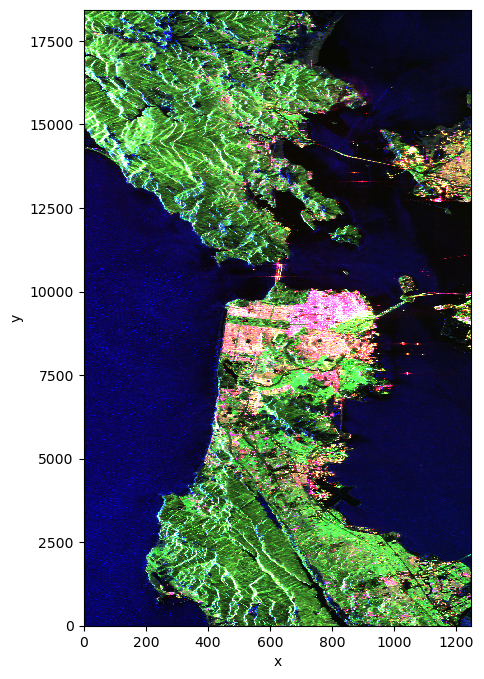

In [4]:
# open the file
T3_flt = open_netcdf_beam(output_test_dir / f"T3_refined_lee.nc")

# make an rgb image from diagonal elements
rgb = xr.concat([T3_flt.m22, T3_flt.m33, T3_flt.m11], dim="band")

# compute clipping values to handle the high dynamic range
clip_val = 3 * rgb.mean(dim=("x", "y"))

# clip, normalize and display the image
(rgb.clip(0, clip_val) / clip_val).plot.imshow(figsize=(5,8))